In [1]:
# CELL 1 — Runtime Check (Use GPU)
import torch
print('torch:', torch.__version__)
print('cuda :', torch.cuda.is_available())
if not torch.cuda.is_available():
    print('WARNING: CPU runtime will be very slow.')
    print('Colab: Runtime > Change runtime type > T4 GPU')


torch: 2.9.0+cu128
cuda : True


In [2]:
# CELL 2 — Install Dependencies
!pip -q install -U pip
!pip -q install kaggle torch torchvision numpy scikit-learn pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.6 MB/s eta 0:00:00


In [3]:
# CELL 3 — Kaggle Credentials (Upload kaggle.json)
# Kaggle: Account settings > API > Create New API Token

from google.colab import files
import os, shutil

uploaded = files.upload()  # choose kaggle.json
assert 'kaggle.json' in uploaded, 'Please upload kaggle.json'

os.makedirs('/root/.kaggle', exist_ok=True)
shutil.copyfile('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)
print('Configured Kaggle at /root/.kaggle/kaggle.json')


Saving kaggle.json to kaggle.json
Configured Kaggle at /root/.kaggle/kaggle.json


In [4]:
# CELL 4 — Download + Unzip Dataset
# Dataset: rm1000/brain-tumor-mri-scans

import os
DATA_DIR = '/content/data'
os.makedirs(DATA_DIR, exist_ok=True)

!kaggle datasets download -d rm1000/brain-tumor-mri-scans -p {DATA_DIR} --unzip --force

print('DATA_DIR contents:')
!ls -lah {DATA_DIR} | sed -n '1,140p'


Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 53% 125M/236M [00:00<00:00, 1.30GB/s]
100% 236M/236M [00:00<00:00, 770MB/s] 
DATA_DIR contents:
total 172K
drwxr-xr-x 6 root root 4.0K Feb 18 07:37 .
drwxr-xr-x 1 root root 4.0K Feb 18 07:36 ..
drwxr-xr-x 2 root root  36K Feb 18 07:36 glioma
drwxr-xr-x 2 root root  48K Feb 18 07:36 healthy
drwxr-xr-x 2 root root  36K Feb 18 07:36 meningioma
drwxr-xr-x 2 root root  40K Feb 18 07:37 pituitary


In [5]:


import os

def is_image(name: str) -> bool:
    n = name.lower()
    return n.endswith(('.png','.jpg','.jpeg','.tif','.tiff'))

def looks_like_class_root(root: str) -> bool:
    if not os.path.isdir(root):
        return False
    subs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]
    if len(subs) < 2:
        return False
    ok = 0
    for d in subs:
        p = os.path.join(root,d)
        try:
            if any(is_image(f) for f in os.listdir(p)):
                ok += 1
        except Exception:
            pass
    return ok >= 2

def looks_like_train_test(root: str) -> bool:
    return os.path.isdir(os.path.join(root,'Training')) and os.path.isdir(os.path.join(root,'Testing'))

def find_root(search_root: str) -> str:
    # Common case
    cand = os.path.join(search_root, 'brain-tumor-mri-scans')
    if looks_like_train_test(cand) or looks_like_class_root(cand):
        return cand

    # Shallow walk
    for dirpath, dirnames, filenames in os.walk(search_root):
        depth = dirpath[len(search_root):].count(os.sep)
        if depth > 3:
            dirnames[:] = []
            continue
        if looks_like_train_test(dirpath) or looks_like_class_root(dirpath):
            return dirpath

    raise SystemExit('Could not find dataset root. Check CELL 4 output.')

DATA_ROOT = find_root('/content/data')
print('Using DATA_ROOT:', DATA_ROOT)
print('Top-level:', [d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT,d))][:20])


Using DATA_ROOT: /content/data
Top-level: ['meningioma', 'pituitary', 'glioma', 'healthy']


In [ ]:
# CELL 6 — Write Project Script
%%writefile /content/dtfl_backdoor_fltrust.py
#!/usr/bin/env python3


import argparse
import copy
import json
import math
import os
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Dataset, Subset




SEED = 42
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

DEFAULT_ROOT = "/kaggle/input/brain-tumor-mri-scans"
DEFAULT_OUT_DIR = "/tmp/logs_attack_defense"

NUM_CLIENTS = 12
DIRICHLET_ALPHA = 0.3
IMAGE_SIZE = 224
BATCH_SIZE = 16
ROUNDS = 20
LOCAL_EPOCHS = 2
LR = 3e-4

# Async behavior
ACTIVE_FRAC = 0.7
DELAY_PROB = 0.15
STALENESS_LAMBDA = 0.4
SERVER_LR = 1.0
SERVER_WARMUP_EPOCHS = 0

# Output verbosity
NO_PROGRESS = False

# Attack settings
ATTACK_KIND = "noise"
TARGET_CLASS = 0
POISON_FRAC = 0.30
PATCH_SIZE = 18
PATCH_VALUE = 2.8
MODEL_REPLACEMENT_SCALE = 2.0
SIGNFLIP_SCALE = 3.0
NOISE_SCALE = 2.0

# FLTrust settings
ROOT_TRUST_FRAC = 0.10
ROOT_LOCAL_EPOCHS = 2
FLTRUST_PROJECT_REF = False


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(
            [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        )
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = []
        for c in self.classes:
            folder = os.path.join(root_dir, c)
            for f in sorted(os.listdir(folder)):
                if f.lower().endswith(("png", "jpg", "jpeg", "tif", "tiff")):
                    self.samples.append((os.path.join(folder, f), self.class_to_idx[c]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, lbl


def resolve_dataset_roots(root: str) -> tuple:
    """
    Returns (train_root, test_root_or_none).

    Some Kaggle datasets are organized as:
      root/Training/<class>/*
      root/Testing/<class>/*
    Others are just:
      root/<class>/*
    """
    training = os.path.join(root, "Training")
    testing = os.path.join(root, "Testing")
    if os.path.isdir(training) and os.path.isdir(testing):
        return training, testing
    return root, None


def ensure_offline_efficientnet_weights() -> None:

    try:
        torch_home = os.environ.get("TORCH_HOME", None)
        if not torch_home:
            return
        src = os.path.join(torch_home, "checkpoints", "efficientnet_b0_rwightman-7f5810bc.pth")
        if not os.path.exists(src):
            return
        dst_dir = os.path.join(torch_home, "hub", "checkpoints")
        os.makedirs(dst_dir, exist_ok=True)
        dst = os.path.join(dst_dir, os.path.basename(src))
        if not os.path.exists(dst):
            import shutil

            shutil.copyfile(src, dst)
    except Exception:
        # Best-effort only; if this fails, torchvision may still download.
        return


class SimpleEffNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        ensure_offline_efficientnet_weights()
        self.backbone = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        in_f = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(in_f, num_classes))

        # More stable fine-tuning than freezing a raw % of parameters:
        # freeze all feature blocks, then unfreeze the last 2 blocks.
        for p in self.backbone.features.parameters():
            p.requires_grad = False
        for block in list(self.backbone.features.children())[-2:]:
            for p in block.parameters():
                p.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


def create_dirichlet_split_from_indices(dataset, indices_pool, num_clients, alpha, min_size=30):
    idx_by_class = defaultdict(list)
    for idx in indices_pool:
        _, y = dataset.samples[idx]
        idx_by_class[y].append(idx)

    client_map = {i: [] for i in range(num_clients)}
    for _, idxs in idx_by_class.items():
        idxs = idxs.copy()
        np.random.shuffle(idxs)
        props = np.random.dirichlet([alpha] * num_clients)
        counts = (props * len(idxs)).astype(int)
        counts[-1] = len(idxs) - counts[:-1].sum()
        ptr = 0
        for i in range(num_clients):
            client_map[i].extend(idxs[ptr : ptr + counts[i]])
            ptr += counts[i]

    small = [c for c in client_map if len(client_map[c]) < min_size]
    big = [c for c in client_map if len(client_map[c]) >= min_size]
    leftover = []
    for c in small:
        leftover.extend(client_map[c])
        client_map[c] = []
    if leftover and big:
        np.random.shuffle(leftover)
        share = len(leftover) // len(big)
        for i, c in enumerate(big):
            s = i * share
            e = s + share if i < len(big) - 1 else len(leftover)
            client_map[c].extend(leftover[s:e])

    return client_map


def stamp_patch(xb, patch_size=PATCH_SIZE, patch_value=PATCH_VALUE):
    x = xb.clone()
    x[:, :, -patch_size:, -patch_size:] = patch_value
    return x


def evaluate(model, loader):
    if len(loader.dataset) == 0:
        return 0.0, 0.0, 0.0, 0.0
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb).argmax(1)
            preds.extend(out.cpu().numpy().tolist())
            labels.extend(yb.cpu().numpy().tolist())
    acc = 100.0 * accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    return acc, prec, rec, f1


def evaluate_backdoor_asr(model, loader, target_class=TARGET_CLASS):
    model.eval()
    succ, tot = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            mask = yb != target_class
            if mask.sum().item() == 0:
                continue
            x_clean = xb[mask]
            x_trigger = stamp_patch(x_clean)
            pred = model(x_trigger.to(DEVICE)).argmax(1).cpu()
            succ += (pred == target_class).sum().item()
            tot += pred.numel()
    return 100.0 * succ / tot if tot > 0 else 0.0


def local_train(global_model, loader, epochs, lr, attack_cfg=None):
    if len(loader.dataset) == 0:
        return copy.deepcopy(global_model), 0.0

    model = copy.deepcopy(global_model).to(DEVICE)
    model.train()
    opt = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=5e-4
    )
    use_amp = (DEVICE.type == "cuda")

    try:
        scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
        autocast = torch.amp.autocast
    except Exception:
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        autocast = torch.cuda.amp.autocast
    loss_fn = nn.CrossEntropyLoss()
    losses = []

    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            if attack_cfg is not None and attack_cfg["enabled"]:
                poison_mask = torch.rand(yb.size(0), device=yb.device) < attack_cfg["poison_frac"]
                poison_mask = poison_mask & (yb != attack_cfg["target_class"])
                if poison_mask.any():
                    xb = xb.clone()
                    yb = yb.clone()
                    xb[poison_mask] = stamp_patch(
                        xb[poison_mask],
                        patch_size=attack_cfg["patch_size"],
                        patch_value=attack_cfg["patch_value"],
                    )
                    yb[poison_mask] = attack_cfg["target_class"]

            opt.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                out = model(xb)
                loss = loss_fn(out, yb)
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(
                [p for p in model.parameters() if p.requires_grad], 1.0
            )
            scaler.step(opt)
            scaler.update()
            losses.append(float(loss.detach().cpu()))

    return model, float(np.mean(losses)) if losses else 0.0


def state_delta(local_state, global_state):
    out = OrderedDict()
    for k in global_state:
        if global_state[k].dtype == torch.int64:
            out[k] = torch.zeros_like(global_state[k])
        else:
            out[k] = (local_state[k] - global_state[k]).detach().clone()
    return out


def trainable_state_keys(model: nn.Module) -> set:
    # state_dict keys for parameters (excludes buffers like running_mean/var).
    return set(dict(model.named_parameters()).keys())


def scale_delta(delta, s):
    out = OrderedDict()
    for k, v in delta.items():
        out[k] = v if v.dtype == torch.int64 else (v * s)
    return out


def apply_delta(model, delta, scale=1.0):
    state = model.state_dict()
    pkeys = trainable_state_keys(model)
    new_state = OrderedDict()
    for k in state:
        if state[k].dtype == torch.int64:
            new_state[k] = state[k]
        elif k in pkeys:
            new_state[k] = state[k] + scale * delta[k].to(state[k].device)
        else:
            # Keep non-parameter buffers stable (BN running stats, etc.)
            new_state[k] = state[k]
    model.load_state_dict(new_state)


def make_noise_delta_like(delta, pkeys, scale):
    """
    Create a random Gaussian update with norm ~= scale * ||delta|| over trainable params.
    """
    out = OrderedDict()
    ref_norm_sq = 0.0
    rand_norm_sq = 0.0
    for k, v in delta.items():
        if k not in pkeys or v.dtype == torch.int64:
            out[k] = torch.zeros_like(v)
            continue
        ref_norm_sq += float(torch.sum(v.detach().float() ** 2).item())
        r = torch.randn_like(v, dtype=torch.float32).to(v.dtype)
        out[k] = r
        rand_norm_sq += float(torch.sum(r.detach().float() ** 2).item())

    ref_norm = math.sqrt(max(ref_norm_sq, 1e-12))
    rand_norm = math.sqrt(max(rand_norm_sq, 1e-12))
    factor = float(scale) * ref_norm / rand_norm
    for k in list(out.keys()):
        if k in pkeys and out[k].dtype != torch.int64:
            out[k] = out[k] * factor
    return out


def delta_norm(delta, pkeys=None):
    s = 0.0
    for k, v in delta.items():
        if pkeys is not None and k not in pkeys:
            continue
        if v.dtype != torch.int64:
            s += float(torch.sum(v.float() ** 2).item())
    return math.sqrt(max(s, 1e-18))


def delta_dot(d1, d2, pkeys=None):
    s = 0.0
    for k in d1:
        if pkeys is not None and k not in pkeys:
            continue
        if d1[k].dtype != torch.int64:
            s += float(torch.sum(d1[k].float() * d2[k].float()).item())
    return s


def cosine_sim(d1, d2, pkeys=None):
    return delta_dot(d1, d2, pkeys=pkeys) / (delta_norm(d1, pkeys=pkeys) * delta_norm(d2, pkeys=pkeys) + 1e-12)


def zero_delta_like(state):
    out = OrderedDict()
    for k, v in state.items():
        out[k] = torch.zeros_like(v)
    return out


def add_delta(a, b):
    out = OrderedDict()
    for k in a:
        out[k] = a[k] if a[k].dtype == torch.int64 else (a[k] + b[k])
    return out


def weighted_aggregate(arrivals, global_state, stale_lambda):
    if len(arrivals) == 0:
        return zero_delta_like(global_state)
    agg = zero_delta_like(global_state)
    denom = 0.0
    for upd in arrivals:
        w = upd["samples"] * math.exp(-stale_lambda * upd["staleness"])
        agg = add_delta(agg, scale_delta(upd["delta"], w))
        denom += w
    if denom <= 0:
        return zero_delta_like(global_state)
    return scale_delta(agg, 1.0 / denom)


def make_root_loader(train_root, train_idx, transform_eval):
    n_root = max(32, int(ROOT_TRUST_FRAC * len(train_idx)))
    # Sample a fixed root set (avoid bias from the head of train_idx).
    rng = np.random.RandomState(SEED + 123)
    root_idx = rng.choice(np.array(train_idx), size=n_root, replace=False).tolist()
    root_ds = Subset(BrainTumorDataset(train_root, transform=transform_eval), root_idx)
    g = torch.Generator().manual_seed(SEED + 999)
    return (
        DataLoader(
            root_ds,
            batch_size=BATCH_SIZE,
            shuffle=True,
            generator=g,
            drop_last=True,
        ),
        n_root,
    )


def server_reference_delta(global_model, root_loader, lr):
    local, _ = local_train(global_model, root_loader, ROOT_LOCAL_EPOCHS, lr, attack_cfg=None)
    return state_delta(local.state_dict(), global_model.state_dict())


def fltrust_stale_aggregate(arrivals, global_model, root_loader, lr, stale_lambda):
    g_state = global_model.state_dict()
    if len(arrivals) == 0:
        return zero_delta_like(g_state)

    pkeys = trainable_state_keys(global_model)
    ref = server_reference_delta(global_model, root_loader, lr)
    ref_norm = delta_norm(ref, pkeys=pkeys)
    if ref_norm <= 1e-12:
        return zero_delta_like(g_state)

    ref_norm_sq = ref_norm * ref_norm
    agg = zero_delta_like(g_state)
    denom = 0.0
    for upd in arrivals:
        d = upd["delta"]
        trust = max(0.0, cosine_sim(d, ref, pkeys=pkeys))
        if trust <= 0:
            continue

        if FLTRUST_PROJECT_REF:

            dot = delta_dot(d, ref, pkeys=pkeys)
            if dot <= 0:
                continue
            coeff = dot / (ref_norm_sq + 1e-12)

            coeff = min(1.0, float(coeff))
            d_scaled = scale_delta(ref, coeff)
        else:
            d_norm = delta_norm(d, pkeys=pkeys)
            if d_norm <= 1e-12:
                continue


            clip = min(1.0, ref_norm / d_norm)
            d_scaled = scale_delta(d, clip)

        weight = upd["samples"] * math.exp(-stale_lambda * upd["staleness"]) * trust
        agg = add_delta(agg, scale_delta(d_scaled, weight))
        denom += weight

    if denom <= 0:
        return zero_delta_like(g_state)
    return scale_delta(agg, 1.0 / denom)


def flatten_delta(delta, pkeys):
    parts = []
    for k, v in delta.items():
        if k not in pkeys or v.dtype == torch.int64:
            continue
        parts.append(v.detach().float().flatten().cpu())
    return torch.cat(parts) if parts else torch.zeros(1, dtype=torch.float32)


def krum_aggregate(arrivals, global_model, f):

    g_state = global_model.state_dict()
    if len(arrivals) == 0:
        return zero_delta_like(g_state)

    n = len(arrivals)
    # Krum requires n >= 2f + 3. If not satisfied, fall back to sample-weighted mean.
    if n < 2 * f + 3:
        return weighted_aggregate(arrivals, g_state, stale_lambda=0.0)

    pkeys = trainable_state_keys(global_model)
    vecs = [flatten_delta(upd["delta"], pkeys) for upd in arrivals]
    # Pairwise distances
    dists = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            dij = float(torch.sum((vecs[i] - vecs[j]) ** 2).item())
            dists[i][j] = dij
            dists[j][i] = dij

    # Krum score: sum of closest (n - f - 2) distances
    m = n - f - 2
    scores = []
    for i in range(n):
        ds = sorted(dists[i])
        scores.append(sum(ds[1 : 1 + m]))  # skip self-distance at index 0

    # Multi-Krum: average of the best m updates by score.
    selected = sorted(range(n), key=lambda i: scores[i])[:m]
    agg = zero_delta_like(g_state)
    for i in selected:
        agg = add_delta(agg, arrivals[i]["delta"])
    return scale_delta(agg, 1.0 / max(1, len(selected)))


def foolsgold_aggregate(arrivals, global_model, stale_lambda):

    g_state = global_model.state_dict()
    if len(arrivals) == 0:
        return zero_delta_like(g_state)

    pkeys = trainable_state_keys(global_model)
    vecs = [flatten_delta(upd["delta"], pkeys) for upd in arrivals]
    n = len(vecs)
    if n == 1:
        return arrivals[0]["delta"]

    sims = torch.zeros((n, n), dtype=torch.float32)
    for i in range(n):
        vi = vecs[i]
        ni = torch.norm(vi) + 1e-12
        for j in range(i + 1, n):
            vj = vecs[j]
            nj = torch.norm(vj) + 1e-12
            s = float(torch.dot(vi, vj) / (ni * nj))
            s = max(0.0, min(1.0, s))
            sims[i, j] = s
            sims[j, i] = s

    max_sims = sims.max(dim=1).values
    w = (1.0 - max_sims).clamp(min=0.0, max=1.0)

    if float(w.sum().item()) <= 1e-12:
        return weighted_aggregate(arrivals, g_state, stale_lambda=stale_lambda)

    agg = zero_delta_like(g_state)
    denom = 0.0
    for upd, wi in zip(arrivals, w.tolist()):
        if wi <= 0:
            continue
        weight = wi * upd["samples"] * math.exp(-stale_lambda * upd["staleness"])
        agg = add_delta(agg, scale_delta(upd["delta"], weight))
        denom += weight
    if denom <= 0:
        return zero_delta_like(g_state)
    return scale_delta(agg, 1.0 / denom)


def trimmed_mean_aggregate(arrivals, global_model, trim_ratio):

    g_state = global_model.state_dict()
    if len(arrivals) == 0:
        return zero_delta_like(g_state)

    n = len(arrivals)
    b = int(trim_ratio * n)
    if n <= 2 * b:
        # Not enough clients to trim on both sides safely.
        return weighted_aggregate(arrivals, g_state, stale_lambda=0.0)

    out = OrderedDict()
    for k, v in g_state.items():
        if v.dtype == torch.int64:
            out[k] = torch.zeros_like(v)
            continue
        vals = torch.stack([upd["delta"][k].detach().float() for upd in arrivals], dim=0)
        vals, _ = torch.sort(vals, dim=0)
        kept = vals[b : n - b]
        out[k] = kept.mean(dim=0).to(v.dtype)
    return out


def run_experiment(
    client_loaders,
    central_val_loader,
    central_test_loader,
    num_classes,
    defense_kind,
    root_loader,
    server_lr,
    server_warmup_epochs,
    krum_f,
    attack_kind,
    signflip_scale,
    noise_scale,
    trim_ratio,
):

    set_seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    model = SimpleEffNet(num_classes=num_classes).to(DEVICE)
    pkeys = trainable_state_keys(model)
    pending = defaultdict(list)
    logs = []


    if server_warmup_epochs > 0:
        model, _ = local_train(
            model,
            root_loader,
            epochs=int(server_warmup_epochs),
            lr=LR,
            attack_cfg=None,
        )

    for r in range(ROUNDS):
        active = []
        for cid in client_loaders:

            if random.random() < ACTIVE_FRAC:
                active.append(cid)

        for cid in active:
            is_mal = cid in MALICIOUS_CLIENTS
            attack_cfg = None
            if attack_kind == "backdoor":
                attack_cfg = {
                    "enabled": is_mal,
                    "poison_frac": POISON_FRAC,
                    "target_class": TARGET_CLASS,
                    "patch_size": PATCH_SIZE,
                    "patch_value": PATCH_VALUE,
                }
            local_model, _ = local_train(
                model,
                client_loaders[cid]["train"],
                LOCAL_EPOCHS,
                LR,
                attack_cfg=attack_cfg,
            )

            d = state_delta(local_model.state_dict(), model.state_dict())

            for k in list(d.keys()):
                if k not in pkeys and d[k].dtype != torch.int64:
                    d[k].zero_()
            if is_mal:
                if attack_kind == "signflip":

                    d = scale_delta(d, -abs(signflip_scale))
                elif attack_kind == "noise":

                    d = make_noise_delta_like(d, pkeys=pkeys, scale=noise_scale)
                else:
                    d = scale_delta(d, MODEL_REPLACEMENT_SCALE)


            if MAX_DELAY <= 0:
                delay = 0
            elif random.random() < DELAY_PROB:
                delay = random.randint(1, MAX_DELAY)
            else:
                delay = 0
            pending[r + delay].append(
                {
                    "client": cid,
                    "samples": len(client_loaders[cid]["train"].dataset),
                    "staleness": delay,
                    "delta": d,
                    "malicious": is_mal,
                }
            )


        arrivals = pending.pop(r, [])

        if defense_kind == "fltrust":
            agg = fltrust_stale_aggregate(
                arrivals=arrivals,
                global_model=model,
                root_loader=root_loader,
                lr=LR,
                stale_lambda=STALENESS_LAMBDA,
            )
        elif defense_kind == "krum":
            agg = krum_aggregate(arrivals=arrivals, global_model=model, f=krum_f)
        elif defense_kind == "foolsgold":
            agg = foolsgold_aggregate(arrivals=arrivals, global_model=model, stale_lambda=STALENESS_LAMBDA)
        elif defense_kind == "trimmed_mean":
            agg = trimmed_mean_aggregate(arrivals=arrivals, global_model=model, trim_ratio=trim_ratio)
        else:
            agg = weighted_aggregate(arrivals, model.state_dict(), STALENESS_LAMBDA)

        apply_delta(model, agg, scale=server_lr)

        val_acc, val_prec, val_rec, val_f1 = evaluate(model, central_val_loader)
        asr = evaluate_backdoor_asr(model, central_val_loader, target_class=TARGET_CLASS)
        logs.append(
            {
                "round": r,
                "arrivals": len(arrivals),
                "active": len(active),
                "val_acc": val_acc,
                "val_prec": val_prec,
                "val_rec": val_rec,
                "val_f1": val_f1,
                "val_backdoor_asr": asr,
            }
        )

        if not NO_PROGRESS:
            tag = "DEF" if defense_kind not in (None, "none") else "NO-DEF"
            print(
                f"[Round {r:02d}] {tag} "
                f"| arrivals={len(arrivals):2d} | active={len(active):2d} "
                f"| val_acc={val_acc:6.2f}% | val_asr={asr:6.2f}%",
                flush=True,
            )

    test_acc, test_prec, test_rec, test_f1 = evaluate(model, central_test_loader)
    test_asr = evaluate_backdoor_asr(model, central_test_loader, target_class=TARGET_CLASS)
    summary = {
        "test_acc": test_acc,
        "test_prec": test_prec,
        "test_rec": test_rec,
        "test_f1": test_f1,
        "test_backdoor_asr": test_asr,
    }
    return model, logs, summary


def print_summary_line(label: str, summary: dict) -> None:
    print(
        f"{label:<18} | "
        f"acc={summary['test_acc']:.2f}% | "
        f"prec={summary['test_prec']:.4f} | "
        f"rec={summary['test_rec']:.4f} | "
        f"f1={summary['test_f1']:.4f} | "
        f"ASR={summary['test_backdoor_asr']:.2f}%"
    )


def main():
    global ROUNDS, LOCAL_EPOCHS, BATCH_SIZE, NUM_CLIENTS, DIRICHLET_ALPHA, LR
    global ACTIVE_FRAC, DELAY_PROB, MAX_DELAY, STALENESS_LAMBDA
    global SERVER_LR, SERVER_WARMUP_EPOCHS
    global NO_PROGRESS
    global FLTRUST_PROJECT_REF
    global MALICIOUS_CLIENTS, ATTACK_KIND, SIGNFLIP_SCALE, NOISE_SCALE
    global TARGET_CLASS, POISON_FRAC, PATCH_SIZE, PATCH_VALUE, MODEL_REPLACEMENT_SCALE
    global ROOT_TRUST_FRAC, ROOT_LOCAL_EPOCHS

    parser = argparse.ArgumentParser()
    parser.add_argument("--root", type=str, default=DEFAULT_ROOT, help="Dataset root (ImageFolder-style).")
    parser.add_argument("--out-dir", type=str, default=DEFAULT_OUT_DIR, help="Where to write logs/results JSON.")
    parser.add_argument("--rounds", type=int, default=ROUNDS)
    parser.add_argument("--local-epochs", type=int, default=LOCAL_EPOCHS)
    parser.add_argument("--batch-size", type=int, default=BATCH_SIZE)
    parser.add_argument("--num-clients", type=int, default=NUM_CLIENTS)
    parser.add_argument("--dirichlet-alpha", type=float, default=DIRICHLET_ALPHA)
    parser.add_argument("--lr", type=float, default=LR)
    parser.add_argument(
        "--active-frac",
        type=float,
        default=ACTIVE_FRAC,
        help="Fraction of clients active in each round (0..1).",
    )
    parser.add_argument(
        "--delay-prob",
        type=float,
        default=DELAY_PROB,
        help="For active clients, probability that an update is delayed (arrives in a later round).",
    )
    parser.add_argument("--max-delay", type=int, default=MAX_DELAY)
    parser.add_argument("--staleness-lambda", type=float, default=STALENESS_LAMBDA)
    parser.add_argument("--server-lr", type=float, default=SERVER_LR)
    parser.add_argument(
        "--server-warmup-epochs",
        type=int,
        default=SERVER_WARMUP_EPOCHS,
        help="If >0, warm-start the global model on the clean FLTrust root set before FL rounds.",
    )
    parser.add_argument(
        "--mode",
        type=str,
        default="both",
        choices=["both", "attack_only", "attack_plus_fltrust", "attack_plus_krum", "attack_plus_foolsgold", "attack_plus_trimmed_mean"],
        help="Which run(s) to execute. Use attack_only and attack_plus_fltrust for separate Colab cells.",
    )
    parser.add_argument(
        "--krum-f",
        type=int,
        default=2,
        help="Assumed number of Byzantine clients for Krum (used when --mode attack_plus_krum).",
    )
    parser.add_argument(
        "--trim-ratio",
        type=float,
        default=0.2,
        help="Trim ratio for coordinate-wise trimmed-mean defense (used when --mode attack_plus_trimmed_mean).",
    )
    parser.add_argument(
        "--no-progress",
        action="store_true",
        help="Hide per-round progress prints (cleaner Colab output).",
    )
    parser.add_argument("--num-malicious", type=int, default=len(MALICIOUS_CLIENTS))
    parser.add_argument(
        "--attack-kind",
        type=str,
        default=ATTACK_KIND,
        choices=["backdoor", "signflip", "noise"],
        help="Type of malicious behavior used by malicious clients.",
    )
    parser.add_argument(
        "--signflip-scale",
        type=float,
        default=SIGNFLIP_SCALE,
        help="Amplification for sign-flip model poisoning (used when --attack-kind signflip).",
    )
    parser.add_argument(
        "--noise-scale",
        type=float,
        default=NOISE_SCALE,
        help="Amplitude for random-noise poisoning (used when --attack-kind noise).",
    )
    parser.add_argument("--target-class", type=int, default=TARGET_CLASS)
    parser.add_argument("--poison-frac", type=float, default=POISON_FRAC)
    parser.add_argument("--patch-size", type=int, default=PATCH_SIZE)
    parser.add_argument("--patch-value", type=float, default=PATCH_VALUE)
    parser.add_argument("--model-replacement-scale", type=float, default=MODEL_REPLACEMENT_SCALE)
    parser.add_argument("--fltrust-root-frac", type=float, default=ROOT_TRUST_FRAC)
    parser.add_argument("--fltrust-root-epochs", type=int, default=ROOT_LOCAL_EPOCHS)
    parser.add_argument(
        "--fltrust-project-ref",
        action="store_true",
        help="Project accepted client updates onto the FLTrust server reference direction (reduces backdoor ASR).",
    )
    parser.add_argument(
        "--max-client-train-samples",
        type=int,
        default=0,
        help="If >0, cap each client's local TRAIN set size (speeds up runs).",
    )
    parser.add_argument(
        "--max-central-eval-samples",
        type=int,
        default=0,
        help="If >0, cap central val/test set sizes (speeds up runs).",
    )
    args = parser.parse_args()

    # Override module-level knobs from CLI for reproducible runs.
    ROUNDS = int(args.rounds)
    LOCAL_EPOCHS = int(args.local_epochs)
    BATCH_SIZE = int(args.batch_size)
    NUM_CLIENTS = int(args.num_clients)
    DIRICHLET_ALPHA = float(args.dirichlet_alpha)
    LR = float(args.lr)
    ACTIVE_FRAC = float(args.active_frac)
    DELAY_PROB = float(args.delay_prob)
    MAX_DELAY = int(args.max_delay)
    STALENESS_LAMBDA = float(args.staleness_lambda)
    SERVER_LR = float(args.server_lr)
    SERVER_WARMUP_EPOCHS = int(args.server_warmup_epochs)
    NO_PROGRESS = bool(args.no_progress)
    MALICIOUS_CLIENTS = set(range(int(args.num_malicious)))
    ATTACK_KIND = str(args.attack_kind)
    SIGNFLIP_SCALE = float(args.signflip_scale)
    NOISE_SCALE = float(args.noise_scale)
    TARGET_CLASS = int(args.target_class)
    POISON_FRAC = float(args.poison_frac)
    PATCH_SIZE = int(args.patch_size)
    PATCH_VALUE = float(args.patch_value)
    MODEL_REPLACEMENT_SCALE = float(args.model_replacement_scale)
    ROOT_TRUST_FRAC = float(args.fltrust_root_frac)
    ROOT_LOCAL_EPOCHS = int(args.fltrust_root_epochs)
    FLTRUST_PROJECT_REF = bool(args.fltrust_project_ref)

    set_seed(SEED)
    print("Device:", DEVICE)
    warnings.filterwarnings("ignore", category=FutureWarning)

    root = args.root
    out_dir = args.out_dir
    os.makedirs(out_dir, exist_ok=True)

    if not os.path.isdir(root):
        raise SystemExit(
            f"Dataset root not found: {root}\n"
            "Pass --root /path/to/brain-tumor-mri-scans (it should contain class subfolders)."
        )

    transform_train = T.Compose(
        [
            T.RandomResizedCrop(IMAGE_SIZE),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    transform_eval = T.Compose(
        [
            T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    train_root, test_root = resolve_dataset_roots(root)

    base_ds = BrainTumorDataset(train_root, transform=None)
    num_classes = len(base_ds.classes)
    print("Classes:", base_ds.classes)
    print("Total samples:", len(base_ds))

    all_idx = np.arange(len(base_ds))
    all_y = np.array([base_ds.samples[i][1] for i in range(len(base_ds))], dtype=np.int64)
    if test_root is None:

        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
        tr_i, rest_i = next(sss.split(np.zeros(len(all_idx)), all_y))
        train_idx = all_idx[tr_i]
        rest_idx = all_idx[rest_i]

        rest_y = all_y[rest_idx]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED + 1)
        val_i, test_i = next(sss2.split(np.zeros(len(rest_idx)), rest_y))
        val_idx = rest_idx[val_i]
        test_idx = rest_idx[test_i]
    else:

        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
        tr_i, val_i = next(sss.split(np.zeros(len(all_idx)), all_y))
        train_idx = all_idx[tr_i]
        val_idx = all_idx[val_i]
        test_idx = None

    central_val_loader = DataLoader(
        Subset(
            BrainTumorDataset(train_root, transform_eval),
            (val_idx[: args.max_central_eval_samples] if args.max_central_eval_samples > 0 else val_idx).tolist(),
        ),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    if test_root is None:
        central_test_loader = DataLoader(
            Subset(
                BrainTumorDataset(train_root, transform_eval),
                (test_idx[: args.max_central_eval_samples] if args.max_central_eval_samples > 0 else test_idx).tolist(),
            ),
            batch_size=BATCH_SIZE,
            shuffle=False,
        )
    else:
        test_ds = BrainTumorDataset(test_root, transform_eval)
        if args.max_central_eval_samples > 0:
            test_ds = Subset(test_ds, list(range(min(args.max_central_eval_samples, len(test_ds)))))
        central_test_loader = DataLoader(
            test_ds,
            batch_size=BATCH_SIZE,
            shuffle=False,
        )

    client_map = create_dirichlet_split_from_indices(
        base_ds, train_idx, NUM_CLIENTS, DIRICHLET_ALPHA, min_size=30
    )
    client_loaders = {}
    for cid, idxs in client_map.items():
        idxs_sh = idxs.copy()
        np.random.shuffle(idxs_sh)
        n_local_train = int(0.85 * len(idxs_sh))
        tr_idx = idxs_sh[:n_local_train]
        vl_idx = idxs_sh[n_local_train:]
        if args.max_client_train_samples > 0:
            tr_idx = tr_idx[: args.max_client_train_samples]
        client_loaders[cid] = {
            "train": DataLoader(
                Subset(BrainTumorDataset(train_root, transform_train), tr_idx),
                batch_size=BATCH_SIZE,
                shuffle=True,
            ),
            "val": DataLoader(
                Subset(BrainTumorDataset(train_root, transform_eval), vl_idx),
                batch_size=BATCH_SIZE,
                shuffle=False,
            ),
        }

    root_loader, n_root = make_root_loader(train_root, train_idx, transform_eval)
    print(f"FLTrust root set size: {n_root}")

    logs_no_def = []
    logs_def = []
    summary_no_def = None
    summary_def = None
    defense_label = None

    if args.mode in ("both", "attack_only"):
        print("\n=== Running attack-only (no defense) ===")
        _, logs_no_def, summary_no_def = run_experiment(
            client_loaders=client_loaders,
            central_val_loader=central_val_loader,
            central_test_loader=central_test_loader,
            num_classes=num_classes,
            defense_kind="none",
            root_loader=root_loader,
            server_lr=SERVER_LR,
            server_warmup_epochs=SERVER_WARMUP_EPOCHS,
            krum_f=int(args.krum_f),
            attack_kind=ATTACK_KIND,
            signflip_scale=SIGNFLIP_SCALE,
            noise_scale=NOISE_SCALE,
            trim_ratio=float(args.trim_ratio),
        )

    if args.mode in ("both", "attack_plus_fltrust", "attack_plus_krum", "attack_plus_foolsgold", "attack_plus_trimmed_mean"):
        if args.mode == "attack_plus_krum":
            defense_label = "krum"
            print("\n=== Running attack + Krum defense ===")
            _, logs_def, summary_def = run_experiment(
                client_loaders=client_loaders,
                central_val_loader=central_val_loader,
                central_test_loader=central_test_loader,
                num_classes=num_classes,
                defense_kind="krum",
                root_loader=root_loader,
                server_lr=SERVER_LR,
                server_warmup_epochs=SERVER_WARMUP_EPOCHS,
                krum_f=int(args.krum_f),
                attack_kind=ATTACK_KIND,
                signflip_scale=SIGNFLIP_SCALE,
                noise_scale=NOISE_SCALE,
                trim_ratio=float(args.trim_ratio),
            )
        elif args.mode == "attack_plus_trimmed_mean":
            defense_label = "trimmed_mean"
            print("\n=== Running attack + Trimmed-Mean defense ===")
            _, logs_def, summary_def = run_experiment(
                client_loaders=client_loaders,
                central_val_loader=central_val_loader,
                central_test_loader=central_test_loader,
                num_classes=num_classes,
                defense_kind="trimmed_mean",
                root_loader=root_loader,
                server_lr=SERVER_LR,
                server_warmup_epochs=SERVER_WARMUP_EPOCHS,
                krum_f=int(args.krum_f),
                attack_kind=ATTACK_KIND,
                signflip_scale=SIGNFLIP_SCALE,
                noise_scale=NOISE_SCALE,
                trim_ratio=float(args.trim_ratio),
            )
        elif args.mode == "attack_plus_foolsgold":
            defense_label = "foolsgold"
            print("\n=== Running attack + FoolsGold defense ===")
            _, logs_def, summary_def = run_experiment(
                client_loaders=client_loaders,
                central_val_loader=central_val_loader,
                central_test_loader=central_test_loader,
                num_classes=num_classes,
                defense_kind="foolsgold",
                root_loader=root_loader,
                server_lr=SERVER_LR,
                server_warmup_epochs=SERVER_WARMUP_EPOCHS,
                krum_f=int(args.krum_f),
                attack_kind=ATTACK_KIND,
                signflip_scale=SIGNFLIP_SCALE,
                noise_scale=NOISE_SCALE,
                trim_ratio=float(args.trim_ratio),
            )
        else:
            defense_label = "fltrust"
            print("\n=== Running attack + FLTrust defense ===")
            _, logs_def, summary_def = run_experiment(
                client_loaders=client_loaders,
                central_val_loader=central_val_loader,
                central_test_loader=central_test_loader,
                num_classes=num_classes,
                defense_kind="fltrust",
                root_loader=root_loader,
                server_lr=SERVER_LR,
                server_warmup_epochs=SERVER_WARMUP_EPOCHS,
                krum_f=int(args.krum_f),
                attack_kind=ATTACK_KIND,
                signflip_scale=SIGNFLIP_SCALE,
                noise_scale=NOISE_SCALE,
                trim_ratio=float(args.trim_ratio),
            )

    out = {
        "config": {
            "seed": SEED,
            "mode": args.mode,
            "num_clients": NUM_CLIENTS,
            "dirichlet_alpha": DIRICHLET_ALPHA,
            "rounds": ROUNDS,
            "local_epochs": LOCAL_EPOCHS,
            "active_frac": ACTIVE_FRAC,
            "delay_prob": DELAY_PROB,
            "max_delay": MAX_DELAY,
            "staleness_lambda": STALENESS_LAMBDA,
            "server_lr": SERVER_LR,
            "server_warmup_epochs": SERVER_WARMUP_EPOCHS,
            "defense": defense_label,
            "krum_f": int(args.krum_f),
            "trim_ratio": float(args.trim_ratio),
            "malicious_clients": sorted(list(MALICIOUS_CLIENTS)),
            "attack_kind": ATTACK_KIND,
            "signflip_scale": SIGNFLIP_SCALE,
            "noise_scale": NOISE_SCALE,
            "target_class": TARGET_CLASS,
            "poison_frac": POISON_FRAC,
            "patch_size": PATCH_SIZE,
            "patch_value": PATCH_VALUE,
            "model_replacement_scale": MODEL_REPLACEMENT_SCALE,
            "fltrust_root_frac": ROOT_TRUST_FRAC,
            "fltrust_root_epochs": ROOT_LOCAL_EPOCHS,
            "fltrust_project_ref": FLTRUST_PROJECT_REF,
        },
        "attack_only": {"summary": summary_no_def, "round_logs": logs_no_def} if summary_no_def is not None else None,
        "attack_plus_fltrust": {"summary": summary_def, "round_logs": logs_def} if summary_def is not None and defense_label == "fltrust" else None,
        "attack_plus_krum": {"summary": summary_def, "round_logs": logs_def} if summary_def is not None and defense_label == "krum" else None,
        "attack_plus_foolsgold": {"summary": summary_def, "round_logs": logs_def} if summary_def is not None and defense_label == "foolsgold" else None,
        "attack_plus_trimmed_mean": {"summary": summary_def, "round_logs": logs_def} if summary_def is not None and defense_label == "trimmed_mean" else None,

    }

    out_path = os.path.join(out_dir, "attack_vs_fltrust_results.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(out, f, indent=2)

    print("\n=== Final Test Results ===")
    if summary_no_def is not None:
        print_summary_line("No defense", summary_no_def)
    if summary_def is not None:
        print_summary_line(f"{(defense_label or 'Defense').upper()} defense", summary_def)
    print("Saved:", out_path)


if __name__ == "__main__":
    main()


Writing /content/dtfl_backdoor_fltrust.py


In [ ]:
# CELL 8 — Attack Only (NO DEFENSE) in ASYNCHRONOUS DTFL (30 rounds)
# Attack: random-noise model poisoning

import os, time, json, subprocess

ATTACK_ONLY_OUT = f"/content/results_attack_only_{int(time.time())}"
cmd = [
  'python3','/content/dtfl_backdoor_fltrust.py',
  '--root', DATA_ROOT,
  '--out-dir', ATTACK_ONLY_OUT,
  '--mode','attack_only',
  '--attack-kind','noise',
  '--noise-scale','2.0',
  '--num-clients','12',
  '--num-malicious','4',

  # True DTFL async behavior
  '--active-frac','0.6',
  '--delay-prob','0.15',
  '--staleness-lambda','0.5',

  '--dirichlet-alpha','0.3',
  '--rounds','30','--local-epochs','1','--batch-size','32',
  '--server-warmup-epochs','5','--server-lr','1.0',
  '--max-central-eval-samples','800',
]
subprocess.run(cmd, check=True)

p = os.path.join(ATTACK_ONLY_OUT, 'attack_vs_fltrust_results.json')
d = json.load(open(p, 'r', encoding='utf-8'))
summary = d['attack_only']['summary']
print("\nATTACK ONLY (ASYNC, NO DEFENSE) — FINAL TEST METRICS")
print("acc={:.2f}%  prec={:.4f}  rec={:.4f}  f1={:.4f}".format(
    summary['test_acc'], summary['test_prec'], summary['test_rec'], summary['test_f1']
))
print("config -> active_frac={}, delay_prob={}, max_delay={}".format(
    d['config'].get('active_frac'), d['config'].get('delay_prob'), d['config'].get('max_delay')
))
print("\nPER-ROUND VALIDATION LOGS")
for r in d['attack_only']['round_logs']:
    print("round={:02d} arrivals={} active={} val_acc={:.2f}%".format(
        r['round'], r['arrivals'], r['active'], r['val_acc']
    ))
print("\nSaved JSON:", p)



ATTACK ONLY (ASYNC, NO DEFENSE) — FINAL TEST METRICS
acc=51.07%  prec=0.7921  rec=0.4858  f1=0.4507
config -> active_frac=0.6, delay_prob=0.7, max_delay=4

PER-ROUND VALIDATION LOGS
round=00 arrivals=3 active=8 val_acc=88.46%
round=01 arrivals=5 active=10 val_acc=87.61%
round=02 arrivals=4 active=6 val_acc=81.91%
round=03 arrivals=7 active=9 val_acc=85.47%
round=04 arrivals=12 active=8 val_acc=75.07%
round=05 arrivals=7 active=7 val_acc=74.50%
round=06 arrivals=8 active=10 val_acc=78.63%
round=07 arrivals=4 active=6 val_acc=66.24%
round=08 arrivals=11 active=8 val_acc=66.81%
round=09 arrivals=5 active=8 val_acc=67.24%
round=10 arrivals=6 active=3 val_acc=69.52%
round=11 arrivals=6 active=7 val_acc=67.81%
round=12 arrivals=9 active=6 val_acc=67.24%
round=13 arrivals=3 active=6 val_acc=62.39%
round=14 arrivals=7 active=8 val_acc=59.69%
round=15 arrivals=6 active=9 val_acc=53.99%
round=16 arrivals=3 active=4 val_acc=41.31%
round=17 arrivals=9 active=4 val_acc=46.15%
round=18 arrivals=7 a

In [ ]:
# CELL 9 — Attack + Trimmed-Mean Defense in ASYNCHRONOUS DTFL (30 rounds)


import os, time, json, subprocess

DEF_OUT = f"/content/results_attack_def_{int(time.time())}"
cmd = [
  'python3','/content/dtfl_backdoor_fltrust.py',
  '--root', DATA_ROOT,
  '--out-dir', DEF_OUT,
  '--mode','attack_plus_trimmed_mean',
  '--attack-kind','noise',
  '--noise-scale','2.0',
  '--num-clients','12',
  '--num-malicious','4',
  '--trim-ratio','0.2',

  # True DTFL async behavior
  '--active-frac','0.6',
  '--delay-prob','0.15',
  '--staleness-lambda','0.5',

  '--dirichlet-alpha','0.3',
  '--rounds','30','--local-epochs','1','--batch-size','32',
  '--server-warmup-epochs','5','--server-lr','1.0',
  '--max-central-eval-samples','800',
]
subprocess.run(cmd, check=True)

p = os.path.join(DEF_OUT, 'attack_vs_fltrust_results.json')
d = json.load(open(p, 'r', encoding='utf-8'))
summary = d['attack_plus_trimmed_mean']['summary']
cfg = d['config']
print("\nATTACK + TRIMMED-MEAN DEFENSE (ASYNC) — FINAL TEST METRICS")
print("acc={:.2f}%  prec={:.4f}  rec={:.4f}  f1={:.4f}".format(
    summary['test_acc'], summary['test_prec'], summary['test_rec'], summary['test_f1']
))
print("config -> attack_kind={}, defense={}, active_frac={}, delay_prob={}, max_delay={}, staleness_lambda={}".format(
    cfg.get('attack_kind'), cfg.get('defense'), cfg.get('active_frac'), cfg.get('delay_prob'), cfg.get('max_delay'), cfg.get('staleness_lambda')
))
print("\nPER-ROUND VALIDATION LOGS")
for r in d['attack_plus_trimmed_mean']['round_logs']:
    print("round={:02d} arrivals={} active={} val_acc={:.2f}%".format(
        r['round'], r['arrivals'], r['active'], r['val_acc']
    ))
print("\nSaved JSON:", p)



ATTACK + TRIMMED-MEAN DEFENSE (ASYNC) — FINAL TEST METRICS
acc=88.48%  prec=0.8885  rec=0.8774  f1=0.8792
config -> attack_kind=noise, defense=trimmed_mean, active_frac=0.6, delay_prob=0.7, max_delay=4, staleness_lambda=0.5

PER-ROUND VALIDATION LOGS
round=00 arrivals=3 active=8 val_acc=88.18%
round=01 arrivals=5 active=10 val_acc=86.32%
round=02 arrivals=4 active=6 val_acc=83.48%
round=03 arrivals=7 active=9 val_acc=82.62%
round=04 arrivals=12 active=8 val_acc=78.63%
round=05 arrivals=7 active=7 val_acc=84.33%
round=06 arrivals=8 active=10 val_acc=85.04%
round=07 arrivals=4 active=6 val_acc=79.20%
round=08 arrivals=11 active=8 val_acc=80.63%
round=09 arrivals=5 active=8 val_acc=85.19%
round=10 arrivals=6 active=3 val_acc=86.18%
round=11 arrivals=6 active=7 val_acc=84.62%
round=12 arrivals=9 active=6 val_acc=85.04%
round=13 arrivals=3 active=6 val_acc=83.90%
round=14 arrivals=7 active=8 val_acc=84.33%
round=15 arrivals=6 active=9 val_acc=83.33%
round=16 arrivals=3 active=4 val_acc=82.

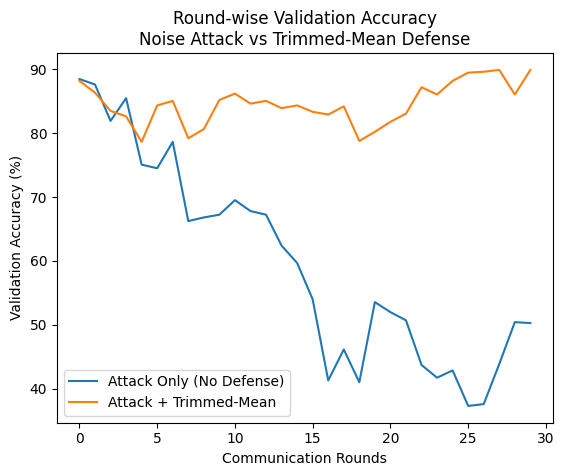

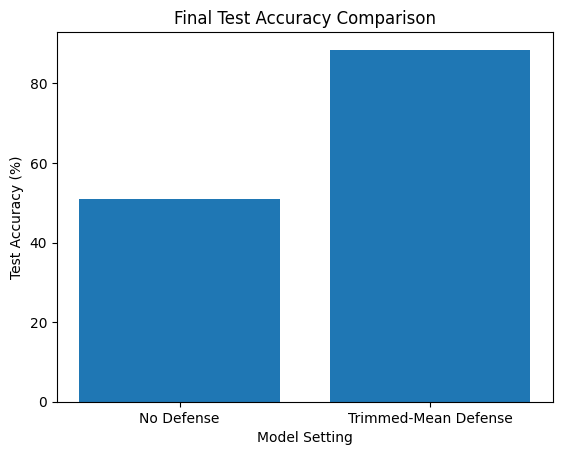

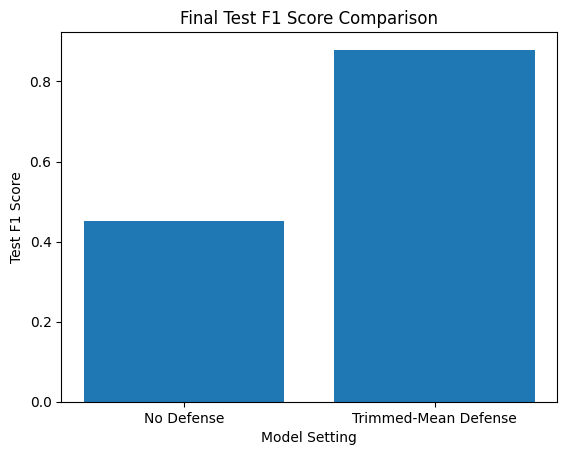

In [10]:
import json
import matplotlib.pyplot as plt
import os

# --------- ───── ╧ Provide Paths ╨ ─────
# Explicitly define ATTACK_ONLY_OUT and DEF_OUT from previous successful executions
ATTACK_ONLY_OUT = "/content/results_attack_only_1771400276"
DEF_OUT = "/content/results_attack_def_1771401063"

attack_json = os.path.join(ATTACK_ONLY_OUT, "attack_vs_fltrust_results.json")
defense_json = os.path.join(DEF_OUT, "attack_vs_fltrust_results.json")

# ⚠️ Replaced xxxx with your actual folder timestamps using ATTACK_ONLY_OUT and DEF_OUT variables


# --------- ───── ╧ Load JSON Files ╨ ─────
with open(attack_json, 'r') as f:
    attack_data = json.load(f)

with open(defense_json, 'r') as f:
    defense_data = json.load(f)


# --------- ───── ╧ Extract Round-wise Accuracy ╨ ─────
attack_rounds = attack_data['attack_only']['round_logs']
defense_rounds = defense_data['attack_plus_trimmed_mean']['round_logs']

attack_val_acc = [r['val_acc'] for r in attack_rounds]
defense_val_acc = [r['val_acc'] for r in defense_rounds]

rounds = list(range(len(attack_val_acc)))


# --------- ───── ╧ Extract Final Test Metrics ╨ ─────
attack_summary = attack_data['attack_only']['summary']
defense_summary = defense_data['attack_plus_trimmed_mean']['summary']

attack_test_acc = attack_summary['test_acc']
defense_test_acc = defense_summary['test_acc']

attack_test_f1 = attack_summary['test_f1']
defense_test_f1 = defense_summary['test_f1']


# =====================================================
# 📈 1‰ Round-wise Validation Accuracy Plot
# =====================================================

plt.figure()
plt.plot(rounds, attack_val_acc)
plt.plot(rounds, defense_val_acc)
plt.xlabel("Communication Rounds")
plt.ylabel("Validation Accuracy (%)")
plt.title("Round-wise Validation Accuracy\nNoise Attack vs Trimmed-Mean Defense")
plt.legend(["Attack Only (No Defense)", "Attack + Trimmed-Mean"])
plt.show()


# =====================================================
# 📊 2‰ Final Test Accuracy Comparison
# =====================================================

plt.figure()
plt.bar(["No Defense", "Trimmed-Mean Defense"],
        [attack_test_acc, defense_test_acc])
plt.xlabel("Model Setting")
plt.ylabel("Test Accuracy (%)")
plt.title("Final Test Accuracy Comparison")
plt.show()


# =====================================================
# 📊 3‰ Final Test F1 Score Comparison
# =====================================================

plt.figure()
plt.bar(["No Defense", "Trimmed-Mean Defense"],
        [attack_test_f1, defense_test_f1])
plt.xlabel("Model Setting")
plt.ylabel("Test F1 Score")
plt.title("Final Test F1 Score Comparison")
plt.show()

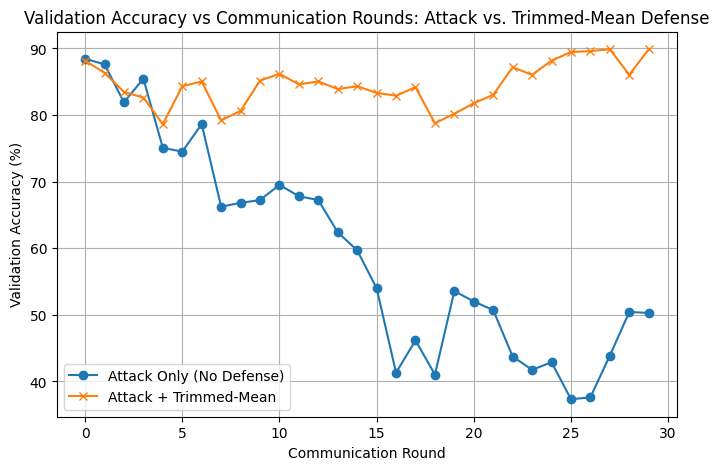

In [11]:
plt.figure(figsize=(8,5))
plt.plot(rounds, attack_val_acc, marker='o', label='Attack Only (No Defense)')
plt.plot(rounds, defense_val_acc, marker='x', label='Attack + Trimmed-Mean')
plt.xlabel("Communication Round")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Communication Rounds: Attack vs. Trimmed-Mean Defense")
plt.grid(True)
plt.legend()
plt.show()